In [1]:
import torch
import matplotlib.pyplot as plt
import numpy as np
import os

import arviz as az

In [2]:
INFERENCE_CKPT = '/mnt/home/dheurtel/ceph/04_inference/sbc'

In [3]:
os.listdir(INFERENCE_CKPT)

['ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine_0.pt',
 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine_3.pt',
 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine_4.pt',
 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine_1.pt',
 'ContinuousSBM_ContinuousVPSDE_I_BPROJ_bottleneck_16_firstc_6_phi_beta_cosine_2.pt']

In [7]:
ckpt_list = [os.path.join(INFERENCE_CKPT, ckpt) for ckpt in os.listdir(INFERENCE_CKPT)]

In [10]:
ckpt_list = [torch.load(ckpt) for ckpt in ckpt_list]

In [50]:
### Define a function that detects stuck chains and returns the indices of the chains that are NOT stuck
### Every chain has an independent truth from the others.

def detect_stuck_chains(samples, threshold_std = 0.02, threshold_tv = 0.1):
    """
    Detects stuck chains
    """

    # compute the std of the samples for each chain and the total variation along each chain
    
    std = samples.std(axis=0)
    tv = torch.abs(samples[1:] - samples[:-1]).mean(dim=0)

    # if the std is below a threshold, the chain is stuck

    stuck_chains = std < threshold_std

    return torch.logical_and(stuck_chains[:,0], stuck_chains[:,1])

def chain_close_to_boundary(targets, threshold_distance = 0.1):
    """
    Detects chains that are close to the boundary, the boundary is the boundary of the square [-1,1]x[-1,1]
    """

    # compute the distance to the boundary for each chain

    distance_to_boundary = torch.min(torch.abs(targets - 1), torch.abs(targets + 1))

    ## Reduce along the dimension of the space the chains live in

    distance_to_boundary = distance_to_boundary.mean(dim=-1)

    # if the distance to the boundary is below a threshold, the chain is close to the boundary

    return distance_to_boundary < threshold_distance
    

In [51]:
ckpt_list[0]['tensor_rphi_list'].shape

torch.Size([1040, 256, 2])

In [71]:
### Concatenate the chains

rphi_true = torch.cat([ckpt['rphi_true'] for ckpt in ckpt_list], dim=0)
rphi_list = torch.cat([ckpt['tensor_rphi_list'] for ckpt in ckpt_list], dim=1)[40:]

In [72]:
rphi_list.shape, rphi_true.shape

(torch.Size([1000, 1280, 2]), torch.Size([1280, 2]))

In [73]:
## Select the relevant chains

stuck_chains = detect_stuck_chains(rphi_list)
boundary_chains = chain_close_to_boundary(rphi_true)

stuck_chains.shape, boundary_chains.shape

(torch.Size([1280]), torch.Size([1280]))

In [75]:
relevant_chains = torch.logical_not(torch.logical_or(stuck_chains, boundary_chains))

relevant_chains.shape

torch.Size([1280])

In [77]:
rphi_true_clean = rphi_true[relevant_chains]
rphi_list_clean = rphi_list[:,relevant_chains]

rphi_true_clean.shape, rphi_list_clean.shape

(torch.Size([1185, 2]), torch.Size([1000, 1185, 2]))

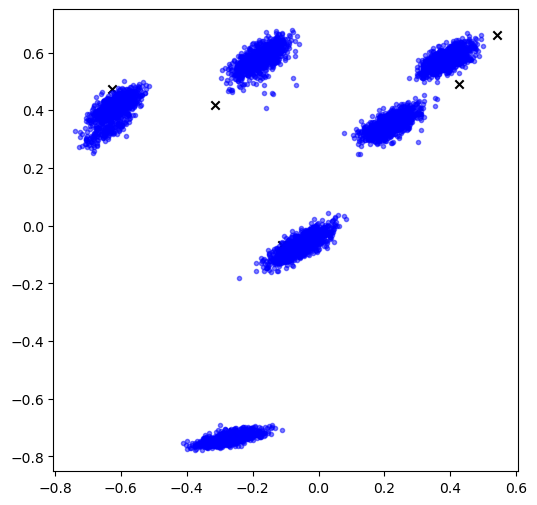

In [85]:
### Selects a few targets and plot the chain associated with it
fig, ax = plt.subplots(1,1, figsize=(6,6))

for _ in range(6):
    i = np.random.randint(0, rphi_true_clean.shape[0])
    ax.scatter(rphi_true_clean[i,0].cpu().detach(), rphi_true_clean[i,1].cpu().detach(), color='black', marker='x')
    ax.scatter(rphi_list_clean[:,i,0].cpu().detach(), rphi_list_clean[:,i,1].cpu().detach(), color='blue', marker='.', alpha=0.5)

In [88]:
stuck_chains.sum()/len(stuck_chains)

tensor(0.0570, device='cuda:0')

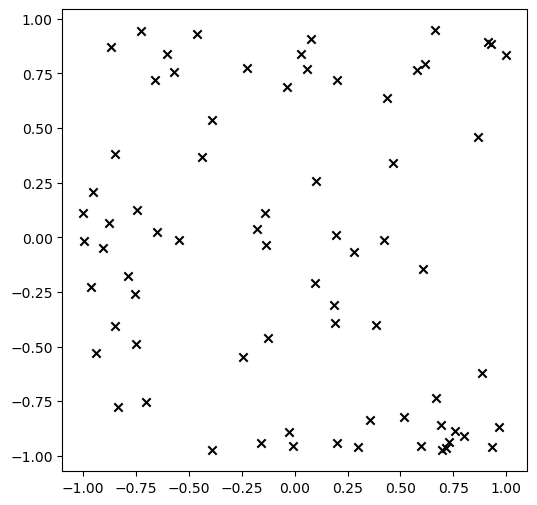

In [86]:
### Plot rphi_true for the stuck chains

fig, ax = plt.subplots(1,1, figsize=(6,6))

for i in range(rphi_true.shape[0]):
    if stuck_chains[i]:
        ax.scatter(rphi_true[i,0].cpu().detach(), rphi_true[i,1].cpu().detach(), color='black', marker='x')

In [157]:
phi_1 = 0.20
phi_2 = 0.80

str_phi_1 = "{:.2f}".format(phi_1)
str_phi_2 = "{:.2f}".format(phi_2)

str_phi_1, str_phi_2

burnin = 14000

xlims = [0, 1]
ylims = [0, 1]

In [158]:
chains = torch.load('data_results/phi_list_{}_{}.pt'.format(str_phi_1, str_phi_2)).cpu().detach().numpy()


In [159]:
chains.shape

(29001, 16, 2)

In [160]:
#chains = chains[burnin:]

Text(0, 0.5, '$\\phi_2$')

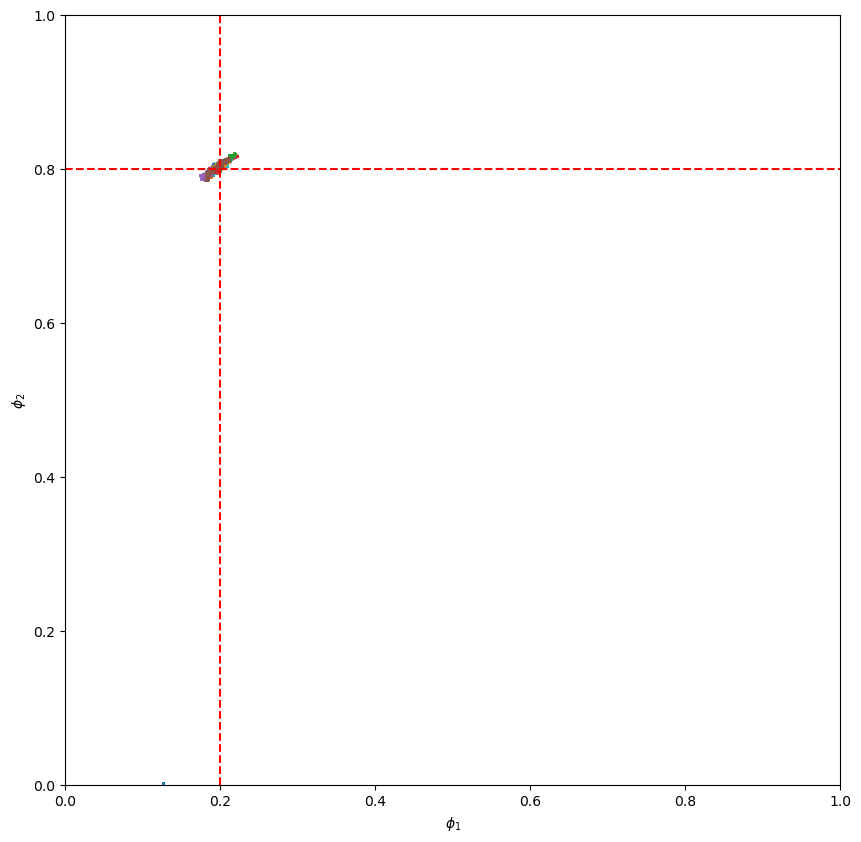

In [161]:
## Plotting the chains of shape (n_samples, n_chains = 16 , n_params = 2)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

for i in range(chains.shape[1]):
    ax.scatter(chains[burnin:, i, 0], chains[burnin:, i, 1], s = 0.2 ,alpha=0.5)

ax.axhline(phi_2, color='red', linestyle='--')
ax.axvline(phi_1, color='red', linestyle='--')

ax.set_xlim(xlims)
ax.set_ylim(ylims)

ax.set_xlabel(r'$\phi_1$')
ax.set_ylabel(r'$\phi_2$')

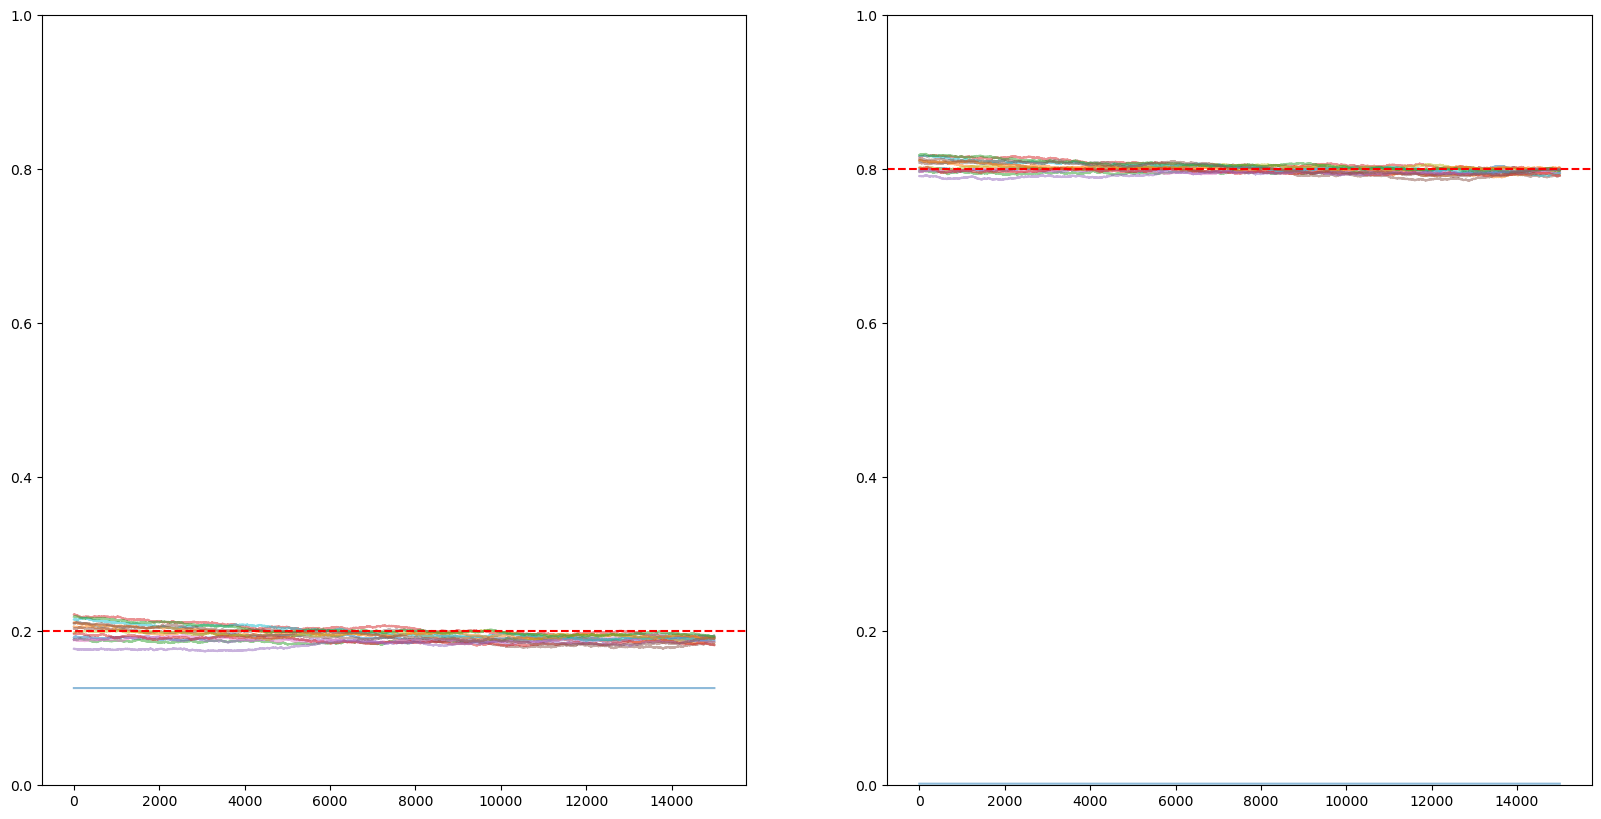

In [162]:
#### Trace plots for the chains of shape (n_samples, n_chains = 16 , n_params = 2)


fig, ax = plt.subplots(1, 2, figsize=(20, 10))

for i in range(chains.shape[1]):
    ax[0].plot(chains[burnin:, i, 0], alpha=0.5)
    ax[1].plot(chains[burnin:, i, 1], alpha=0.5)

## Limits in the y axis
ax[0].set_ylim(ylims)
ax[1].set_ylim(ylims)

ax[0].axhline(phi_1, color='red', linestyle='--')
ax[1].axhline(phi_2, color='red', linestyle='--')

In [168]:
phi_1_list = [0.2, 0.4, 0.6, 0.8]
phi_2_list = [0.2, 0.4, 0.6, 0.8]

k_closest = 4

burnin =26000

def is_converging(chains, phi_1, phi_2, criterion = 0.1):
    """
    For each chain return True if the chain is converging to the target
    """
    phi_1_converging = (np.abs(chains[:, :, 0] - phi_1) < criterion).mean(axis = 0) > 0.5
    phi_2_converging = (np.abs(chains[:, :, 1] - phi_2) < criterion).mean(axis = 0) > 0.5
    return phi_1_converging & phi_2_converging

converging_chains_list = []

In [169]:
for phi_1 in phi_1_list:
    for phi_2 in phi_2_list:
        str_phi_1 = "{:.2f}".format(phi_1)
        str_phi_2 = "{:.2f}".format(phi_2)
        chains = torch.load('data_results/phi_list_{}_{}.pt'.format(str_phi_1, str_phi_2)).cpu().detach().numpy()
        chains = chains[burnin:]
        converging_chains = chains[:, is_converging(chains, phi_1, phi_2, 0.1), :]
        converging_chains_list.append(converging_chains)
        print(phi_1, phi_2, converging_chains.shape)

0.2 0.2 (0, 0, 2)
0.2 0.4 (0, 0, 2)
0.2 0.6 (3001, 0, 2)
0.2 0.8 (3001, 15, 2)
0.4 0.2 (0, 0, 2)
0.4 0.4 (3001, 14, 2)
0.4 0.6 (3001, 15, 2)
0.4 0.8 (3001, 12, 2)
0.6 0.2 (3001, 12, 2)
0.6 0.4 (3001, 1, 2)
0.6 0.6 (3001, 14, 2)
0.6 0.8 (3001, 14, 2)
0.8 0.2 (3001, 15, 2)
0.8 0.4 (3001, 4, 2)
0.8 0.6 (3001, 11, 2)
0.8 0.8 (3001, 14, 2)


/tmp/ipykernel_470466/40476847.py:12: RuntimeWarning: Mean of empty slice.
  phi_1_converging = (np.abs(chains[:, :, 0] - phi_1) < criterion).mean(axis = 0) > 0.5
/mnt/sw/nix/store/pvz51gzx2lyqpabf08xhd1y2kvw5rfdy-python-3.9.16-view/lib/python3.9/site-packages/numpy/core/_methods.py:182: RuntimeWarning: invalid value encountered in divide
  ret = um.true_divide(
/tmp/ipykernel_470466/40476847.py:13: RuntimeWarning: Mean of empty slice.
  phi_2_converging = (np.abs(chains[:, :, 1] - phi_2) < criterion).mean(axis = 0) > 0.5


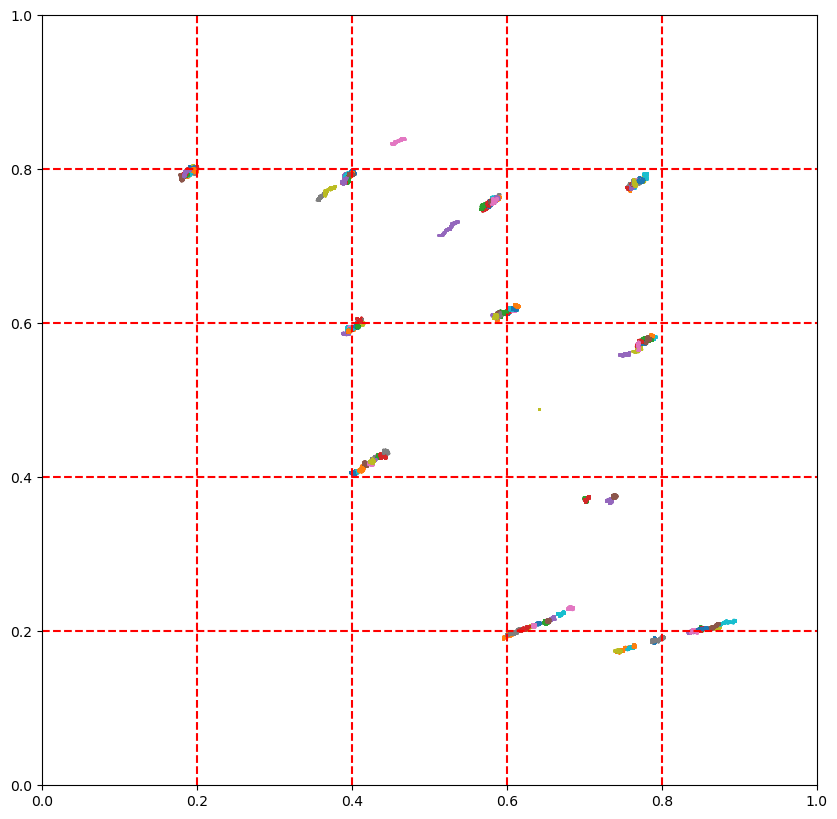

In [170]:
## Plotting all the chains of shape (n_samples, n_chains = 16 , n_params = 2)

fig, ax = plt.subplots(1, 1, figsize=(10, 10))

idx = 0

for phi_1 in phi_1_list:
    for phi_2 in phi_2_list:
        chains = converging_chains_list[idx]
        idx += 1
        for i in range(chains.shape[1]):
            ax.scatter(chains[:, i, 0], chains[:, i, 1], s = 0.2 ,alpha=0.5)
        ax.set_xlim(xlims)
        ax.set_ylim(ylims)
for phi_2 in phi_2_list:
    ax.axhline(phi_2, color='red', linestyle='--')
for phi_1 in phi_1_list:
    ax.axvline(phi_1, color='red', linestyle='--')

In [166]:
### Compute ESS and R hat for each group of chains

def compute_ess_rhat(chains):
    """
    Compute the ESS and R hat for each parameter
    """
    az_infdata = az.convert_to_inference_data(chains[:,:,:])
    ess = az.ess(az_infdata)
    rhat = az.rhat(az_infdata)
    return ess, rhat

In [167]:
for chain in converging_chains_list:
    chain = chain.copy()
    chain = np.moveaxis(chain, 0, 1)
    if chain.shape[0]>2 and chain.shape[1]>4:
        ess, rhat = compute_ess_rhat(chain)
        print(ess['x'].values, chain.shape[0],rhat['x'].values)

[14.61144513 15.15440313] 14 [5.12701193 3.75509896]
[18.00392146 19.98258094] 15 [2.5024976 2.0434381]


[14.58531888 14.62824534] 14 [5.11954094 4.94069376]
[15.96162057 16.10444585] 15 [4.16892001 3.89952809]
[12.53293786 12.82373403] 12 [4.9739626  4.03952292]
[12.48782366 12.60152193] 12 [5.19185585 4.66676569]
[15.01307019 15.59666684] 14 [3.92912418 3.21279581]
[14.61558939 15.30347826] 13 [3.07415278 2.6397411 ]
[14.49705611 14.77745013] 14 [5.55966954 4.44046846]
[4.43831217 5.96920499] 4 [3.33839631 1.76809851]
[12.20211321 12.70769537] 11 [3.25374773 2.79306199]
[15.63310836 16.06249685] 14 [3.15576208 2.83946016]
